# **Model Training**

In [1]:
#Download-Dataset
!git clone https://github.com/ML9-FORCES/extractify-doc

Cloning into 'extractify-doc'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 414 (delta 199), reused 410 (delta 198), pack-reused 0
Receiving objects: 100% (414/414), 15.88 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (199/199), done.


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import json
!pip install scikit-plot
import scikitplot as skplt
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [3]:
#Helper-function - (Required in training Only)
def hot_encode(value):
  encode={'question': 1 ,'other': 0, 'header': 0, 'answer': 2}
  decode={1:'key',2:'value',0:'other'}
  try:
    return encode[value]
  except:
    return decode[value]

class word:
  def __init__(self,data,lab):
    self.id = data['id'] 
    self.coordinate = data['box']
    self.idm = [i[{1:1,2:0}[lab]] for i in data['linking']]
    self.label= lab

def summary(box):
  width=box[2]-box[0]
  height=box[3]-box[1]
  c_x=(box[0]+box[2])/2
  c_y=(box[1]+box[3])/2
  return c_x,c_y,width,height

def feature_extractor(coor):
  b1=summary(coor[0])
  b2=summary(coor[1])
  dis=(b1[0]-b2[0])**2 + (b1[1]-b2[1])**2
  dis=dis**0.5
  sin=(b1[1]-b2[1])/dis
  sin*= -1 if sin<0 else 1
  relative_width = b1[2]/b2[2] if b2[2]>b1[2] else b2[2]/b1[2]
  relative_height = b1[3]/b2[3] if b2[3]>b1[3] else b2[3]/b1[3]
  return dis/1000,sin,relative_width,relative_height

#Extracts data 
def extract(path,n,flag=0):
  dataset={'input':[],'output':[]}
  for filename in os.listdir(path):
    f = os.path.join(path, filename)
    if os.path.isfile(f):
      file_ = open(f)
      form = json.load(file_)
      file_.close()
      key=[]
      value=[]
      for i in form['form']:
        lab=hot_encode(i['label'])
        if lab==1:
          key.append(word(i,lab))
        if lab==2:
          value.append(word(i,lab))
      input=[]
      output=[]
      for i in key:
        for j in value:
          input.append(feature_extractor([i.coordinate,j.coordinate]))
          output.append(1 if j.id in i.idm else 0)
      dataset['input']+=input
      dataset['output']+=output
  dataset['input']=dataset['input']
  dataset['output']=dataset['output']
  buffer_input=[]
  buffer_output=[]
  for i in range(len(dataset['input'])):
    if dataset['output'][i]==1:
      buffer_input.append(dataset['input'][i])
      buffer_output.append(dataset['output'][i])
  for i in range(n):
    dataset['input']+=buffer_input
    dataset['output']+=buffer_output
  if flag==1:
    return dataset
  dataset_ = tf.data.Dataset.from_tensor_slices((np.array(dataset['input']), np.array(dataset['output'])))
  dataset_ = dataset_.shuffle(100000).batch(16, drop_remainder=True)
  return dataset_

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
#Data-Extraction
train_data = extract('extractify-doc/dataset/training_data/annotations',3)
test_data = extract('extractify-doc/dataset/testing_data/annotations',3)

In [13]:
import tensorflow as tf 
from matplotlib import pyplot as plt 
import numpy as np 


model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(4,)), 
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(512, activation='relu'), 
                                    tf.keras.layers.Dense(2, activation=tf.nn.softmax)])
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data,validation_data=test_data, epochs=5)
model.evaluate(test_data)

Epoch 1/5
5446/5446 [==============================] - 20s 4ms/step - loss: 0.1758 - accuracy: 0.9358 - val_loss: 0.1521 - val_accuracy: 0.9349
Epoch 2/5
5446/5446 [==============================] - 20s 4ms/step - loss: 0.1612 - accuracy: 0.9408 - val_loss: 0.1464 - val_accuracy: 0.9418
Epoch 3/5
5446/5446 [==============================] - 20s 4ms/step - loss: 0.1571 - accuracy: 0.9431 - val_loss: 0.1472 - val_accuracy: 0.9405
Epoch 4/5
5446/5446 [==============================] - 20s 4ms/step - loss: 0.1548 - accuracy: 0.9432 - val_loss: 0.1431 - val_accuracy: 0.9427
Epoch 5/5
1514/1514 [==============================] - 3s 2ms/step - loss: 0.1405 - accuracy: 0.9425


[0.1404915452003479, 0.9425363540649414]

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               2560      
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 528,898
Trainable params: 528,898
Non-trainable params: 0
_________________________________________________________________


In [39]:
#model.save('/content/drive/MyDrive/MODELS/linking')
model.save('MODELS/linking')

INFO:tensorflow:Assets written to: MODELS/linking/assets


# **Model-Metrics**

In [32]:
model.evaluate(test_data)

1514/1514 [==============================] - 4s 2ms/step - loss: 0.1406 - accuracy: 0.9425


[0.14059951901435852, 0.9425363540649414]

(0.0, 0.2)

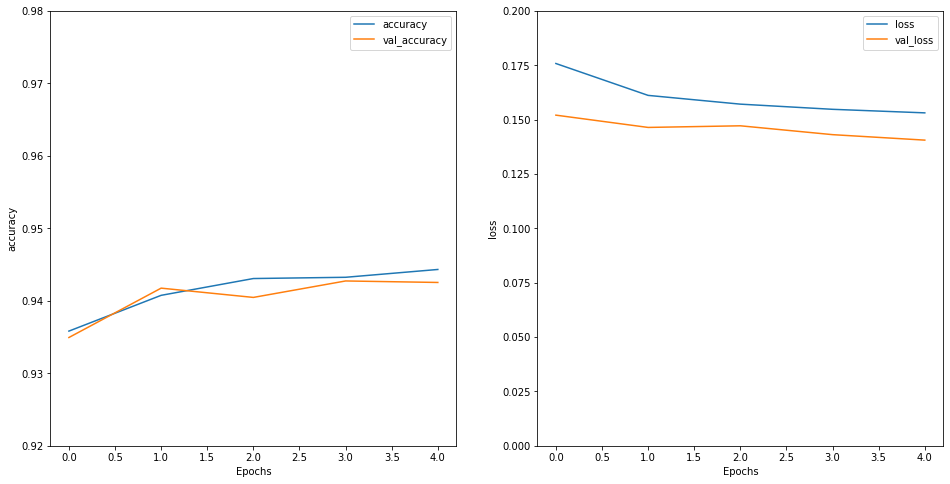

In [33]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0.92, 0.98)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, 0.2)

In [25]:
ds=extract('extractify-doc/dataset/testing_data/annotations',0,1)
y_prob=model.predict(ds['input'])
y_pred=np.array([np.argmax(i) for i in y_prob])
y_true=ds['output']

In [26]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     20890
           1       0.57      0.72      0.64       837

    accuracy                           0.97     21727
   macro avg       0.78      0.85      0.81     21727
weighted avg       0.97      0.97      0.97     21727



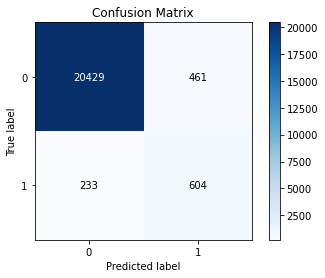

In [34]:
skplt.metrics.plot_confusion_matrix(y_true, y_pred)
plt.show()

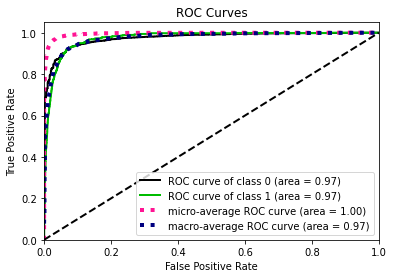

In [35]:
skplt.metrics.plot_roc(y_true,y_prob)

In [36]:
f1_score=metrics.f1_score(y_true,y_pred,average=None)
print('F1-Score')
print('class(0) : not-linking :',f1_score[0])
print('class(1) : linking :',f1_score[1])

F1-Score
class(0) : not-linking : 0.9832980361956103
class(1) : linking : 0.6351209253417456


# **Model Usage**

In [ ]:
!pip install gdown==4.1.1

In [3]:
import tensorflow as tf
import numpy as np
import gdown
import os


class linking_classifier:
  def __init__(self):
    path='./static/MODELS/linking'
    url='https://drive.google.com/drive/folders/1vDUBSS6cXyZdQTwtcXhg8BXBGGR_s7FT'
    if not os.path.isdir(path):
      gdown.download_folder(url,output=path, quiet=False)
    self.model = tf.keras.models.load_model(path)  
 
  def ext(self,box):
    width=box[2]-box[0]
    height=box[3]-box[1]
    c_x=(box[0]+box[2])/2
    c_y=(box[1]+box[3])/2
    return c_x,c_y,width,height

  def preprocessing(self, input_data1,input_data2):
    b1=self.ext(input_data1)
    b2=self.ext(input_data2)
    dis=(b1[0]-b2[0])**2 + (b1[1]-b2[1])**2
    dis=dis**0.5
    sin=(b1[1]-b2[1])/dis
    sin*= -1 if sin<0 else 1
    relative_width = b1[2]/b2[2] if b2[2]>b1[2] else b2[2]/b1[2]
    relative_height = b1[3]/b2[3] if b2[3]>b1[3] else b2[3]/b1[3]
    return [dis/1000,sin,relative_width,relative_height]

  def predict(self, input_data):
    return self.model.predict(np.array([input_data]))[0]

  def postprocessing(self, input_data):
    bins={1:'linked',0:'unlinked'}
    return bins[np.argmax(input_data)],str(np.max(input_data))

  def compute_prediction(self, input_data1,input_data2):
    try:
      input_data = self.preprocessing(input_data1,input_data2)
      prediction = self.predict(input_data)
      prediction = self.postprocessing(prediction)
    except Exception as e:
      return {"status": "Error", "message": str(e)}
    return prediction

In [5]:
#Intialize Model-Object
linker = linking_classifier() 

In [7]:
key_box=[102,345,129,359]          #key bounding box coordinate
value_box=[142,342,236,360]        #value bounding box coordinate
prediction=linker.compute_prediction(key_box,value_box)
print(prediction) #(label,confidence)

('linked', '0.95006293')
